# Question 2. Precision-Recall Curve (PR Curve)

Model performance metrics (precision and recall) on COCO dataset.

The evaluation code is reference from https://github.com/cocodataset/cocoapi/.

In [8]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)
sns.set(rc={'figure.figsize':(20,16)})

In [9]:
annTypes = ['segm','bbox','keypoints']
annType = annTypes[1] 
prefix = 'person_keypoints' if annType=='keypoints' else 'instances'
print('Running demo for *%s* results.'%(annType))

Running demo for *bbox* results.


In [10]:
# ground truth
# downloaded: https://cocodataset.org/#download (2014 Validation annotations)
annFile = '../annotations/instances_val2014.json'
cocoGt=COCO(annFile)

loading annotations into memory...
Done (t=7.94s)
creating index...
index created!


In [11]:
# detection objects
resFile = '../results/instances_val2014_results.json'
cocoDt=cocoGt.loadRes(resFile)

Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!


In [12]:
imgIds=sorted(cocoGt.getImgIds())
imgIds=imgIds[0:100]
# imgId = imgIds[np.random.randint(100)]

## 1. Area Range Adjustment for Calculating Metrics

The previous area range is set in [`cocoapi/PythonAPI/pycocotools/cocoeval.py`](https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/cocoeval.py)
~~~~
class Params:
    def setDetParams(self):
    ...
        self.areaRng = [[0 ** 2, 1e5 ** 2], [0 ** 2, 32 ** 2], [32 ** 2, 96 ** 2], [96 ** 2, 1e5 ** 2]]
    ...
~~~~


I overwrite the previous area range to the new area range as below:  `all`: [0, 100<sup>2</sup>], `small`: [0, 15<sup>2</sup>], `medium`: [15<sup>2</sup>, 32<sup>2</sup>], `large`: [32<sup>2</sup>, 64<sup>2</sup>].  
~~~~
cocoEval.params.areaRng = [[0 ** 2, 1e5 ** 2], [0 ** 2, 15 ** 2], [15 ** 2, 32 ** 2], [32 ** 2, 64 ** 2]]
~~~~

  



In [13]:
# running evaluation
cocoEval = COCOeval(cocoGt,cocoDt,annType)

# new area setting
cocoEval.params.areaRng = [[0 ** 2, 1e5 ** 2], [0 ** 2, 15 ** 2], [15 ** 2, 32 ** 2], [32 ** 2, 64 ** 2]]
#self.areaRngLbl = ['all', 'small', 'medium', 'large']

cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.62s).
Accumulating evaluation results...
DONE (t=0.32s).
Area range: all = [0, 10000000000.0]
Area range: small = [0, 225]
Area range: medium = [225, 1024]
Area range: large = [1024, 4096]
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.505
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.697
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.573
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.596
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.586
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.528
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.387
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.594
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.595
 Average Recall  

## 2. Precision-Recall Curve

### Data Structure

I added the following code in [`cocoapi/PythonAPI/pycocotools/cocoeval.py`](https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/cocoeval.py).  

This allows to save the precision and recall for each of the D detections (dt) under various conditions.  
* `catId` : category ids, `K`
* `areaRng`: object area ranges, [`all`, `small`, `medium`, `large`], `A`=4
* `maxDets`: object area ranges, [1, 10, 100], `M`=3
* `iouThrs`: IoU thresholds, [0,5, 0.55, 0.6, 0.65 ,0.7, 0.75, 0.8, 0.85, 0.9, 0.95], `T`=10

* `dtIds`: id of each dt
* `score`: confidence score of each dt
* `precision`: precision of each dt under the evaluation setting [`t`x`k`x`a`x`m`]
* `recall`: recall of each dt under the evaluation setting [`t`x`k`x`a`x`m`] 

~~~~
def accumulate(self, p = None):
    pr_curve = []

    ....

        for pn, pr_elem in enumerate(pr):
            if pr_elem > 0.0 or rc[pn] > 0.0:
                pr_curve_entry = {}
                pr_curve_entry['catId'] = p.catIds[k0]
                pr_curve_entry['areaRng'] = p.areaRngLbl[a0]
                pr_curve_entry['maxDets'] = maxDet
                pr_curve_entry['iouThrs'] = t_label_list[t]
                pr_curve_entry['dtIds'] = dtIds[pn]
                pr_curve_entry['precision'] = pr_elem
                pr_curve_entry['recall'] = rc[pn]
                pr_curve_entry['score'] = dtScoresSorted[pn]
                pr_curve.append(pr_curve_entry)
    .....

    self.eval = {
                ...
                'pr_curve' : pr_curve,
                ...
            }

~~~~

### Data Manipulation

In [14]:
df = pd.DataFrame.from_dict(cocoEval.eval['pr_curve'])
df.head()

,catId,areaRng,maxDets,iouThrs,dtIds,precision,recall,score
0,1,all,1,0.5,208.0,1.0,0.004,0.997
1,1,all,1,0.5,719.0,1.0,0.008,0.994
2,1,all,1,0.5,350.0,1.0,0.012,0.993
3,1,all,1,0.5,725.0,1.0,0.016,0.975
4,1,all,1,0.5,467.0,1.0,0.020,0.973


In [15]:
df = df.astype({'dtIds': int})

I downloaded the category label to identify which class (category) the category ID corresponds to.
https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/

In [16]:
coco_cat = pd.read_csv('../annotations/coco_categories.txt', delimiter = '\t')
coco_cat = coco_cat[['ID', 'OBJECT(2014 REL.)', 'SUPER_CATEGORY']].rename(columns = {'ID': 'catId', 'OBJECT(2014 REL.)': 'class', 'SUPER_CATEGORY': 'super_category'})

In [17]:
df = pd.merge(df, coco_cat, on='catId', how='left')
df.head()

,catId,areaRng,maxDets,iouThrs,dtIds,precision,recall,score,class,super_category
0,1,all,1,0.5,208,1.0,0.004,0.997,person,person
1,1,all,1,0.5,719,1.0,0.008,0.994,person,person
2,1,all,1,0.5,350,1.0,0.012,0.993,person,person
3,1,all,1,0.5,725,1.0,0.016,0.975,person,person
4,1,all,1,0.5,467,1.0,0.020,0.973,person,person


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46236 entries, 0 to 46235
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   catId           46236 non-null  int64  
 1   areaRng         46236 non-null  object 
 2   maxDets         46236 non-null  int64  
 3   iouThrs         46236 non-null  float64
 4   dtIds           46236 non-null  int64  
 5   precision       46236 non-null  float64
 6   recall          46236 non-null  float64
 7   score           46236 non-null  float64
 8   class           46236 non-null  object 
 9   super_category  46236 non-null  object 
dtypes: float64(4), int64(3), object(3)
memory usage: 3.9+ MB


In [19]:
# missing value check
df['class'].isnull().sum()

0

In [20]:
# precision and recall==-1 for settings with no gt objects
df = df.loc[(df['precision'] > -1) & (df['recall'] > -1)]

In [21]:
# sort according to confidence score
df.sort_values('score', ascending=False, inplace=True, ignore_index=True)

### Class / Super Category Distribution

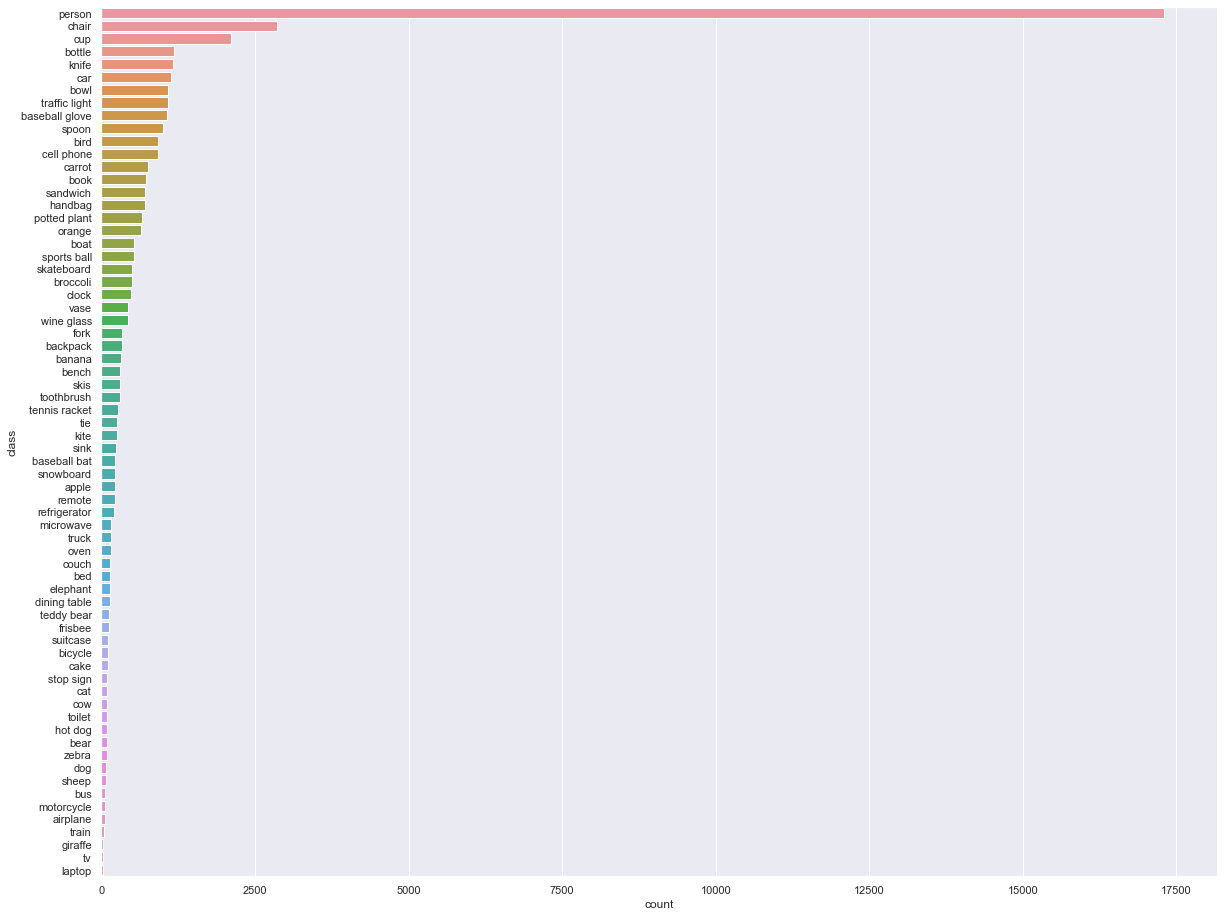

In [22]:
#class distribution
ax = sns.countplot(y='class', data=df, order=df['class'].value_counts().index)

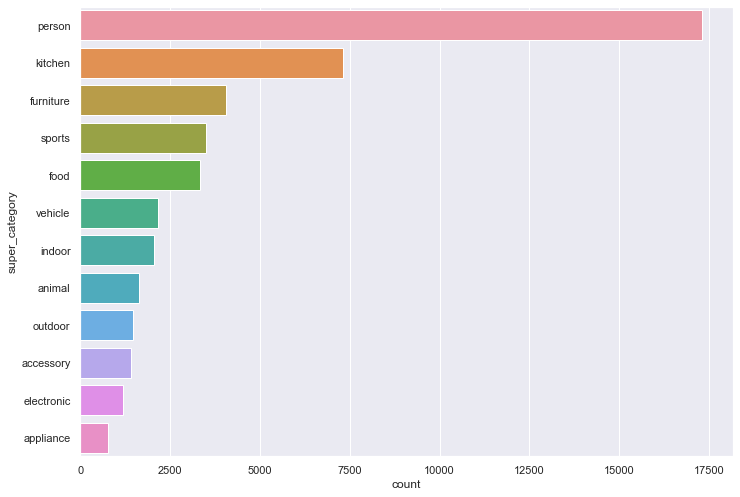

In [23]:
#super category distribution
plt.figure(figsize=(11.7,8.27))
ax = sns.countplot(y='super_category', data=df, order=df['super_category'].value_counts().index)

In [24]:
def getClsInSuperCls(s):
    obj_vehicle = list(df.loc[df['super_category']==s]['class'].unique())
    print("Class lists in super category ``{}``: {}".format(s, obj_vehicle))
    return obj_vehicle

vcls = getClsInSuperCls('vehicle')

Class lists in super category ``vehicle``: ['car', 'truck', 'boat', 'motorcycle', 'airplane', 'bicycle', 'train', 'bus']


### Drawing PR curve 

In [25]:
def drawCatPlot(df, _classlst=None, _areaRng=None, _maxDets=None, _iouThrs=None, _sclst=None, _hue=None): #default: _areaRng='all', _maxDets=100
    df_l = df

    if _sclst is not None:
        df_l = df_l.loc[df_l['super_category'].isin(_sclst)]
        sc_s = ','.join(_sclst)

    if _classlst is not None:
        df_l = df_l.loc[df_l['class'].isin(_classlst)]
        k_s = ','.join(_classlst)
    else: 
        k_s = 'all'

    if _areaRng is not None:
        df_l = df_l.loc[df_l['areaRng'] == _areaRng]
        a_s = _areaRng
    else: 
        a_s = 'all'

    if _maxDets is not None:
        df_l = df_l.loc[df_l['maxDets'] == _maxDets]
        m_s = str(_maxDets)
    else:
        m_s = 'all'
        
    if _iouThrs is not None:
        df_l = df_l.loc[df_l['iouThrs'] == _iouThrs]
        t_s = str(_iouThrs)
    else:
        t_s = 'all'

    # sort according to confidence score
    df_l.sort_values('score', ascending=False, inplace=True, ignore_index=True)

    avg_pr = df_l.groupby(_hue, as_index=False).agg({'precision': 'mean', 'recall': 'mean'}).round(3)[[_hue, 'precision', 'recall']].rename(columns = {'precision' : 'Average Precision (AP)', 'recall': 'Average Recall (AR)'})
    
    if _sclst is not None:
        g_title = "super category:[" +  sc_s + "], areaRng:" + a_s + ", maxDets:" + m_s  + ", iouThrs:" + t_s
    else:
        g_title = "class:[" +  k_s + "], areaRng:" + a_s + ", maxDets:" + m_s  + ", iouThrs:" + t_s

    g = sns.relplot(
        data=df_l, kind="line",
        x="recall", y="precision", 
        hue=_hue, 
        #col="align", size="coherence", style="choice",
        facet_kws=dict(sharex=False))
    (g.set(title=g_title, 
    xlim=(0,1), #ylim=(0,1), 
        )
    )

    return avg_pr

,class,Average Precision (AP),Average Recall (AR)
0,car,0.935,0.436
1,chair,0.906,0.567
2,person,0.855,0.294


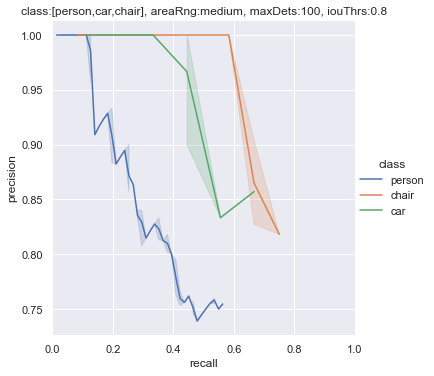

In [26]:
drawCatPlot(df, _classlst=['person', 'car', 'chair'], _maxDets=100, _areaRng='medium', _iouThrs=0.80, _hue='class')

,areaRng,Average Precision (AP),Average Recall (AR)
0,all,0.751,0.339
1,large,0.830,0.446
2,medium,0.850,0.403
3,small,0.847,0.377


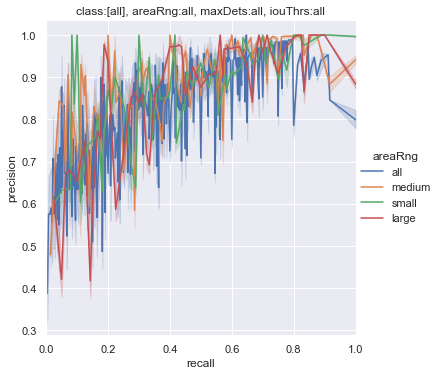

In [27]:
drawCatPlot(df,_hue='areaRng')

,super_category,Average Precision (AP),Average Recall (AR)
0,furniture,0.836,0.389
1,person,0.779,0.293


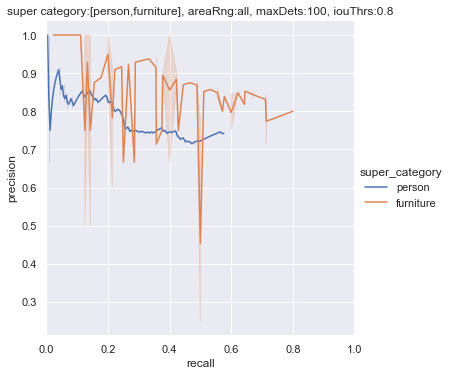

In [28]:
drawCatPlot(df, _maxDets=100, _areaRng='all', _iouThrs=0.8, _sclst=['person', 'furniture'], _hue='super_category')

### Limitations: 

- Zig-zag pattern from the PR curve &rarr;

    * Needs extreme values (outlier) exclusion
    * Try smoothed-out Precision-Recall curve 
